# Final Project - DS325
Aayusha Lamichhane
Megha Shakya 

Instructor - Etai Roth

### Importing packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

### Importing Datasets and Cleaning

In [3]:
# Load data - Control variable
df = pd.read_csv('independent.csv')
df = df.drop(columns=['Series Code'])


# Cleaning Control variable
# From wide to long
df_long = pd.melt(df, id_vars=['Country Name', 'Series Name'],
                  var_name='Year', value_name='amount')

# Convert year to int - need to extract just 4 digits
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})')
df_long = df_long.dropna(subset=['Year'])
df_long['Year'] = df_long['Year'].astype(int) 

# Renaming columns 
df_long = df_long.rename(columns={'Country Name': 'Country', 'Series Name': 'Variable'})

# Keeping Regulatory Quality variable
df_rq = df_long[df_long['Variable'] == 'Regulatory Quality: Estimate']

# Droping and renaming columns
df_rq = df_rq[['Country', 'Year', 'amount']]
df_rq.columns = ['Country', 'Year', 'regulatory_quality']

print(df_rq.head())

          Country  Year regulatory_quality
0     Afghanistan  2002        -1.81154573
1         Albania  2002       -0.311400771
2         Algeria  2002       -0.574951589
3  American Samoa  2002                 ..
4         Andorra  2002        1.422462821


In [4]:
# Load data - Dependent + other control variables
df_con = pd.read_csv('controls.csv')
df_con = df_con.drop(columns=['Series Code'])

# Cleaning Dependent + other control variables
# From wide to long
df_con_long = pd.melt(df_con, id_vars=['Country Name', 'Series Name'],
                      var_name='Year', value_name='amount')

# Convert year to int - need to extract just 4 digits
df_con_long['Year'] = df_con_long['Year'].str.extract(r'(\d{4})')
df_con_long = df_con_long.dropna(subset=['Year'])
df_con_long['Year'] = df_con_long['Year'].astype(int)

# Renaming columns
df_con_long = df_con_long.rename(columns={'Country Name': 'Country', 'Series Name': 'Variable'})

# Renaming variables
# Renaming varibales in dictionary 
name_map = {
   'Control of Corruption: Estimate':                                        'control_corruption',

    'Government Effectiveness: Estimate':                                     'government_effectiveness',
    'Rule of Law: Estimate':                                                  'rule_of_law',
    'Voice and Accountability: Estimate':                                     'voice_accountability',
    'CPIA business regulatory environment rating (1=low to 6=high)':          'reg_env_rating',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990)': 'co2_emissions',
    'Energy imports, net (% of energy use)':                                  'energy_imports_net_pct',
    'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)':    'energy_use_kg_oil',
    'GDP growth (annual %)':                                                  'gdp_growth',
    'Fossil fuel energy consumption (% of total)':                             'fossil_fuel',
    'Renewable energy consumption (% of total final energy consumption)':      'renewable_energy',
    'Renewable internal freshwater resources, total (billion cubic meters)':   'freshwater_resources',
    'Foreign direct investment, net inflows (BoP, current US$)':               'fdi_inflows'
}

# Replacing names in the dataframe
df_con_long['Variable'] = df_con_long['Variable'].map(name_map).fillna(df_con_long['Variable'])

# Pivot so variables are columns
df_con_wide = df_con_long.pivot(index=['Country', 'Year'], columns='Variable', values='amount').reset_index()

# Reordering columns 

df_con_wide.head()

Variable,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy
0,Afghanistan,2002,-67.75374718,..,..,50000000,..,47.15,28.60000117,..,37.8
1,Afghanistan,2003,-65.50544111,..,..,57800000,..,47.15,8.832277803,..,36.7
2,Afghanistan,2004,-69.44425433,..,..,186900000,..,47.15,1.414117993,..,44.2
3,Afghanistan,2005,-56.66621039,..,..,271000000,..,47.15,11.22971483,..,33.9
4,Afghanistan,2006,-51.80685785,..,..,238000000,..,47.15,5.357403247,2.5,31.9


In [5]:
# Merging data

df_merged = pd.merge(df_con_wide, df_rq, on=['Country', 'Year'], how='left')
df_merged.head()

,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy,regulatory_quality
0,Afghanistan,2002,-67.75374718,..,..,50000000,..,47.15,28.60000117,..,37.8,-1.81154573
1,Afghanistan,2003,-65.50544111,..,..,57800000,..,47.15,8.832277803,..,36.7,-1.463107824
2,Afghanistan,2004,-69.44425433,..,..,186900000,..,47.15,1.414117993,..,44.2,-1.511548996
3,Afghanistan,2005,-56.66621039,..,..,271000000,..,47.15,11.22971483,..,33.9,-1.643440247
4,Afghanistan,2006,-51.80685785,..,..,238000000,..,47.15,5.357403247,2.5,31.9,-1.689468622


In [6]:
# Making a copy of existing dataframe to avoid changing the original
df_cleaned = df_merged.copy()

# Converting all object columns (excluding Country) to numeric
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and col != 'Country':
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print(df_cleaned.dtypes)


Country                    object
Year                        int64
co2_emissions             float64
energy_imports_net_pct    float64
energy_use_kg_oil         float64
fdi_inflows               float64
fossil_fuel               float64
freshwater_resources      float64
gdp_growth                float64
reg_env_rating            float64
renewable_energy          float64
regulatory_quality        float64
dtype: object


### Figures (Correlation Matrix and Scatter Plot)

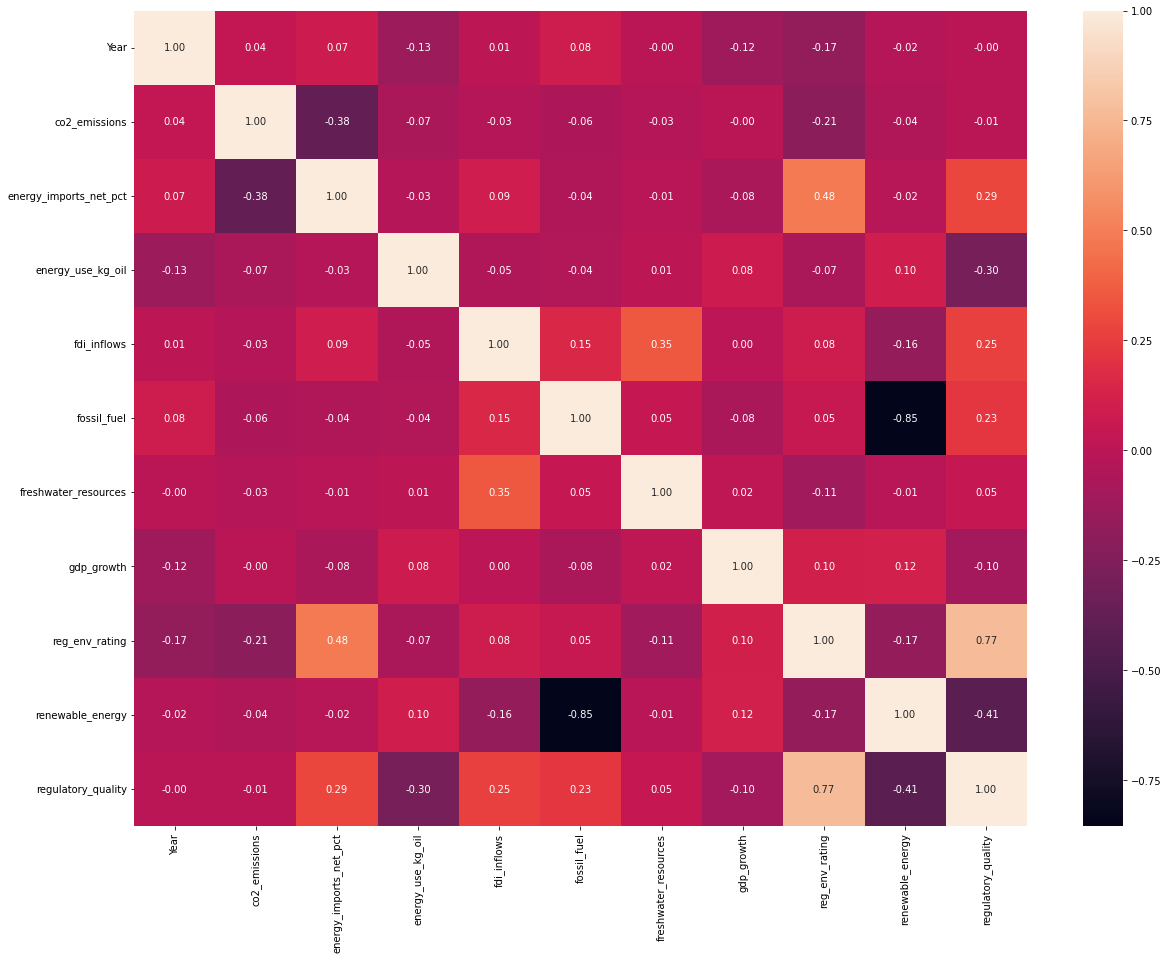

In [7]:
# Correlation matrix

df_corr = df_cleaned.drop(columns=['Country']).corr()

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df_corr, annot=True, fmt='.2f', ax=ax)

plt.savefig("Corr.pdf", format='pdf', bbox_inches='tight')
plt.show()

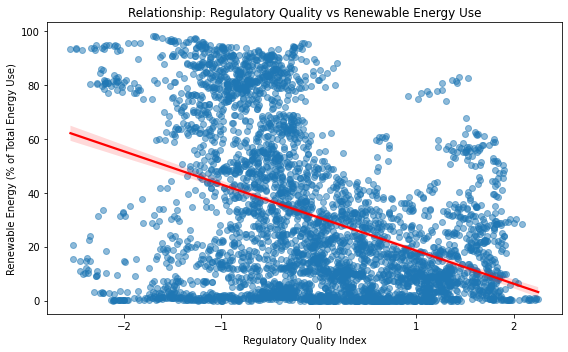

In [8]:
# Independent v/s dependent variable trends graph
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_cleaned,
    x='regulatory_quality',
    y='renewable_energy',
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'}
)
plt.title('Relationship: Regulatory Quality vs Renewable Energy Use')
plt.xlabel('Regulatory Quality Index')
plt.ylabel('Renewable Energy (% of Total Energy Use)')
plt.tight_layout()
plt.show()

### Data Exploration and Cleanup: Removing Unnecessary Rows and Columns

In [9]:
#Checking for  unbalanced panel
missing_by_column = df_cleaned.isnull().mean().sort_values(ascending=False)
print(missing_by_column)

reg_env_rating            0.712082
energy_imports_net_pct    0.425967
energy_use_kg_oil         0.371869
fossil_fuel               0.342617
freshwater_resources      0.271489
renewable_energy          0.140854
fdi_inflows               0.139852
co2_emissions             0.127229
regulatory_quality        0.114406
gdp_growth                0.089160
Country                   0.000000
Year                      0.000000
dtype: float64


In [10]:
# Dropping the columns with more than 50% missing values and years greater than 2021 for missing data
df_cleaned = df_cleaned.drop(columns=['reg_env_rating'])
df_cleaned = df_cleaned[df_cleaned['Year'] <= 2021]

df_cleaned.head(50)

,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,renewable_energy,regulatory_quality
0,Afghanistan,2002,-67.753747,NaN,NaN,5.000000e+07,NaN,47.150,28.600001,37.8,-1.811546
1,Afghanistan,2003,-65.505441,NaN,NaN,5.780000e+07,NaN,47.150,8.832278,36.7,-1.463108
2,Afghanistan,2004,-69.444254,NaN,NaN,1.869000e+08,NaN,47.150,1.414118,44.2,-1.511549
3,Afghanistan,2005,-56.666210,NaN,NaN,2.710000e+08,NaN,47.150,11.229715,33.9,-1.643440
4,Afghanistan,2006,-51.806858,NaN,NaN,2.380000e+08,NaN,47.150,5.357403,31.9,-1.689469
5,Afghanistan,2007,-31.229895,NaN,NaN,1.886900e+08,NaN,47.150,13.826320,28.8,-1.708872
6,Afghanistan,2008,31.181986,NaN,NaN,4.603374e+07,NaN,47.150,3.924984,21.2,-1.607167
7,Afghanistan,2009,108.158237,NaN,NaN,5.610725e+07,NaN,47.150,21.390528,16.5,-1.664508
8,Afghanistan,2010,166.542331,NaN,NaN,1.907744e+08,NaN,47.150,14.362441,15.2,-1.516528
9,Afghanistan,2011,290.414756,NaN,NaN,5.217342e+07,NaN,47.150,0.426355,12.6,-1.536324


In [11]:
# Drop all incomplete rows from the remainiing d
df_no_missing = df_cleaned.dropna()

# Get how many years should exist
expected_years = df_cleaned['Year'].nunique()

# Filter only countries that have data for all years (after dropping NaNs)
df_full_data = df_no_missing.groupby('Country').filter(
    lambda x: x['Year'].nunique() == expected_years
)
df_full_data['Country'].unique()


array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina',
       'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Cameroon', 'Canada',
       'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia', 'Denmark',
       'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea',
       'Estonia', 'Eswatini', 'Finland', 'France', 'Gabon', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'Hungary',
       'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Kenya', 'Korea, Rep.',
       'Kyrgyz Republic', 'Lao PDR', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malaysia', 'Mexico', 'Moldova', 'Mongolia', 'Morocco',
       'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands',
       'New Zealand',

In [12]:
# Checking for  unbalanced panel in the filtered dataset
missing_by_column2 = df_full_data.isnull().mean().sort_values(ascending=False)
print(missing_by_column2)

Country                   0.0
Year                      0.0
co2_emissions             0.0
energy_imports_net_pct    0.0
energy_use_kg_oil         0.0
fdi_inflows               0.0
fossil_fuel               0.0
freshwater_resources      0.0
gdp_growth                0.0
renewable_energy          0.0
regulatory_quality        0.0
dtype: float64


### Grouping Countries by Income

In [13]:
income_group_mapping = {
    'Albania': 'Upper middle income', 'Algeria': 'Upper middle income', 'Angola': 'Lower middle income',
    'Argentina': 'Upper middle income', 'Armenia': 'Lower middle income', 'Australia': 'High income',
    'Austria': 'High income', 'Azerbaijan': 'Upper middle income', 'Bahrain': 'High income',
    'Bangladesh': 'Lower middle income', 'Belarus': 'Upper middle income', 'Belgium': 'High income',
    'Bolivia': 'Lower middle income', 'Bosnia and Herzegovina': 'Upper middle income', 'Brazil': 'Upper middle income',
    'Brunei Darussalam': 'High income', 'Bulgaria': 'Upper middle income', 'Cameroon': 'Lower middle income',
    'Canada': 'High income', 'Chile': 'High income', 'China': 'Upper middle income', 'Colombia': 'Upper middle income',
    'Congo, Dem. Rep.': 'Low income', 'Congo, Rep.': 'Lower middle income', 'Costa Rica': 'Upper middle income',
    "Cote d'Ivoire": 'Lower middle income', 'Croatia': 'High income', 'Czechia': 'High income',
    'Denmark': 'High income', 'Ecuador': 'Upper middle income', 'Egypt, Arab Rep.': 'Lower middle income',
    'El Salvador': 'Lower middle income', 'Equatorial Guinea': 'Low income', 'Estonia': 'High income',
    'Eswatini': 'Low income', 'Finland': 'High income', 'France': 'High income', 'Gabon': 'Upper middle income',
    'Georgia': 'Upper middle income', 'Germany': 'High income', 'Ghana': 'Lower middle income',
    'Greece': 'High income', 'Guatemala': 'Lower middle income', 'Honduras': 'Lower middle income',
    'Hungary': 'High income', 'India': 'Lower middle income', 'Indonesia': 'Lower middle income',
    'Iran, Islamic Rep.': 'Upper middle income', 'Iraq': 'Upper middle income', 'Ireland': 'High income',
    'Israel': 'High income', 'Italy': 'High income', 'Japan': 'High income', 'Kazakhstan': 'Upper middle income',
    'Kenya': 'Lower middle income', 'Korea, Rep.': 'High income', 'Kyrgyz Republic': 'Lower middle income',
    'Lao PDR': 'Lower middle income', 'Latvia': 'High income', 'Lithuania': 'High income',
    'Luxembourg': 'High income', 'Malaysia': 'Upper middle income', 'Mexico': 'Upper middle income',
    'Moldova': 'Lower middle income', 'Mongolia': 'Lower middle income', 'Morocco': 'Lower middle income',
    'Mozambique': 'Low income', 'Myanmar': 'Lower middle income', 'Namibia': 'Upper middle income',
    'Nepal': 'Lower middle income', 'Netherlands': 'High income', 'New Zealand': 'High income',
    'Nicaragua': 'Lower middle income', 'Nigeria': 'Lower middle income', 'North Macedonia': 'Upper middle income',
    'Norway': 'High income', 'Oman': 'High income', 'Pakistan': 'Lower middle income',
    'Panama': 'Upper middle income', 'Paraguay': 'Upper middle income', 'Peru': 'Upper middle income',
    'Philippines': 'Lower middle income', 'Poland': 'High income', 'Portugal': 'High income',
    'Romania': 'Upper middle income', 'Russian Federation': 'Upper middle income', 'Saudi Arabia': 'High income',
    'Senegal': 'Lower middle income', 'Singapore': 'High income', 'Slovak Republic': 'High income',
    'Slovenia': 'High income', 'South Africa': 'Upper middle income', 'Spain': 'High income',
    'Suriname': 'Upper middle income', 'Sweden': 'High income', 'Switzerland': 'High income',
    'Tajikistan': 'Lower middle income', 'Thailand': 'Upper middle income', 'Trinidad and Tobago': 'High income',
    'Tunisia': 'Lower middle income', 'Turkiye': 'Upper middle income', 'Turkmenistan': 'Upper middle income',
    'Uganda': 'Low income', 'Ukraine': 'Lower middle income', 'United Arab Emirates': 'High income',
    'United Kingdom': 'High income', 'United States': 'High income', 'Uruguay': 'High income',
    'Uzbekistan': 'Lower middle income', 'Viet Nam': 'Lower middle income', 'Zambia': 'Lower middle income',
    'Zimbabwe': 'Low income'
}

# mapping and creating a new column
df_full_data['Income_Group'] = df_full_data['Country'].map(income_group_mapping)

print(df_full_data[['Country', 'Income_Group']].drop_duplicates())


         Country         Income_Group
23       Albania  Upper middle income
46       Algeria  Upper middle income
115       Angola  Lower middle income
161    Argentina  Upper middle income
184      Armenia  Lower middle income
...          ...                  ...
4761     Uruguay          High income
4784  Uzbekistan  Lower middle income
4853    Viet Nam  Lower middle income
4945      Zambia  Lower middle income
4968    Zimbabwe           Low income

[112 rows x 2 columns]


### Standard Scaler and Encoding

In [14]:
# We want the income levels to follow a specific order — not alphabetical
income_order = [['Low income', 'Lower middle income', 'Upper middle income', 'High income']]

ordEnc = OrdinalEncoder(categories=income_order)

# ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('ord', ordEnc, ['Income_Group'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Fit and transform
X_trans = ct.fit_transform(df_full_data)

# Converting to DataFrame
encoded_feature_names = ct.get_feature_names_out()
df_encoded_final = pd.DataFrame(X_trans, columns=encoded_feature_names)

df_encoded_final.head(100)

,Income_Group,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,renewable_energy,regulatory_quality
0,2.0,Albania,2002,-39.708051,54.025411,88.606975,135000000.0,63.29,26.9,4.536524,35.8,-0.311401
1,2.0,Albania,2003,-36.626035,51.556771,82.163293,178036400.7,64.59,26.9,5.528637,33.7,-0.490217
2,2.0,Albania,2004,-33.574116,48.369835,85.576922,341285112.5,65.64,26.9,5.514668,35.8,-0.187492
3,2.0,Albania,2005,-37.569601,50.5736,81.182762,262479012.6,66.56,26.9,5.526424,36.8,-0.400731
4,2.0,Albania,2006,-37.777276,41.240008,74.782711,325138316.8,64.51,26.9,5.902659,31.6,-0.148599
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,Armenia,2017,-72.624771,68.960568,77.645091,252747990.7,68.99,6.859,7.5,12.6,0.228397
96,1.0,Armenia,2018,-71.362505,72.731774,71.313001,266855048.8,74.31,6.859,5.2,11.1,0.35059
97,1.0,Armenia,2019,-69.085327,74.170785,71.727843,100287214.4,73.7,6.859,7.6,10.3,0.242604
98,1.0,Armenia,2020,-66.728745,74.147267,81.931163,58582750.12,74.13,6.859,-7.2,8.4,0.238748


In [15]:
df_encoded_final['Income_Group'].unique()

array([2.0, 1.0, 3.0, 0.0], dtype=object)

In [16]:
# For our baseline,  we start with elastic net regression
# Defining X and y
# Drop rows with any NaN
X = df_encoded_final.drop(columns=['renewable_energy', 'Country',])  # features
y = df_encoded_final['renewable_energy']                 # target variabel


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Simple Linear Regression

In [17]:
# basic linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error, r2_score
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))

Linear Regression MSE: 67.88918132298032
Linear Regression R^2: 0.8983623746682858


### Elastic Net Regression (With Grid Search)

In [18]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]  
}

elasticnet = ElasticNet(max_iter=10000)  # high max_iter helps with avoiding convergence issues so we set it to 10,000

grid_search = GridSearchCV(estimator=elasticnet,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.5, 0.9]},
             scoring='r2', verbose=1)

In [19]:
best_elastic = grid_search.best_estimator_
y_pred_elastic = best_elastic.predict(X_test_scaled)

print("Best Parameters:", grid_search.best_params_)
print("Elastic Net Regression MSE:", mean_squared_error(y_test, y_pred_elastic))
print("Elastic Net Regression R^2:", r2_score(y_test, y_pred_elastic))

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Elastic Net Regression MSE: 67.90141644657936
Elastic Net Regression R^2: 0.8983440573328281


### Random Forest Regression

In [20]:
# Trying random forest regression for   non-linear relationships
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators= 50, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R^2:", r2_score(y_test, y_pred_rf))

Random Forest R^2: 0.9867426556789876


### Random Forest Regression with Grid Search

In [21]:
# Adding Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rfgs = RandomForestRegressor(random_state=42)

grid_search_rfgs = GridSearchCV(estimator=rfgs,
                               param_grid=param_grid,
                               cv=5,
                               scoring='r2',
                               verbose=1,
                               n_jobs=-1)  # To make it run faster

grid_search_rfgs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [23]:
best_rf = grid_search_rfgs.best_estimator_
y_pred_rfgs = best_rf.predict(X_test)

print("Best Parameters:", grid_search_rfgs.best_params_)
print("Random Forest with Grid Search R^2:", r2_score(y_test, y_pred_rfgs))
print("Random Forest with Grid Search MSE:", mean_squared_error(y_test, y_pred_rfgs))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest with Grid Search R^2: 0.987951717988773
Random Forest with Grid Search MSE: 8.04768902678571


### Final Figure

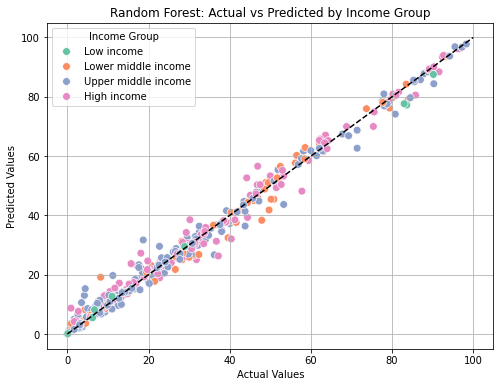

In [ ]:
# To get the income groups for the division of the scatter plot
income_labels = {
    0: 'Low income',
    1: 'Lower middle income',
    2: 'Upper middle income',
    3: 'High income'
}

# Income group name mapping
income_map = df_encoded_final.set_index('Country')['Income_Group'].map(income_labels).to_dict()

# Get country names for y_test
countries = df_encoded_final.loc[y_test.index, 'Country']

# Map income groups
income_group = countries.map(income_map)

# Creatijng DataFrame for plotting
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rfgs,'Income Group': income_group}).dropna()

# Order for the legend
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
plot_data['Income Group'] = pd.Categorical(plot_data['Income Group'], categories=income_order, ordered=True)

# Plotting 
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_data, x='Actual', y='Predicted', hue='Income Group',palette='Set2',s=60)

# Adding X=Y line
plt.plot([0, 100], [0, 100], '--', color='black')

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted by Income Group')
plt.legend(title='Income Group')
plt.grid(True)
plt.savefig("actual_vs_predicted_income.pdf", format='pdf', bbox_inches='tight')
plt.show()